In [21]:
import pandas as pd
import pm4py
from scipy.stats import entropy
from collections import Counter
from operator import itemgetter
from scipy import stats
import numpy as np
import math
import time
import itertools
import shap
import sklearn
from sklearn.model_selection import train_test_split
#https://github.com/slundberg/shap/issues/379

In [22]:
shap.initjs()

In [23]:
log = pm4py.read_xes('DomesticDeclarations.xes_')
dataframe = pm4py.convert_to_dataframe(log)

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

In [24]:
def shapleyDataCalculation(fun,field,dataframe):
    #genera datos en este formato
    # [uno uno dos tres]
    # uno:2
    # dos:1
    # tres:1
    # uno dos tres cuatro var
    # 2    1   1      0     0.5
    # ..........
    
    args=dataframe[field].unique()
    N=np.math.factorial(len(args))
    valuesUsed={}
    valuesFunc=[] #first all values are calculated depending on the possible combinations

    for val in args:
        valuesUsed[val]=[]
    
    #for example if we have {A,B,C}
    for j in range(1,len(args)+1):#counter to generate all possible combinations
        #1->{A}, 2->{{A,B},{A,C}} 3->{A,B,C}
        for i in itertools.combinations(args, j):#generate all possible combinations of size i
            #print(i)
            #if i is 2-> {A,B}, {B,C}, {C,A}
            dataframeComb=dataframe[dataframe[field].isin(i)][field]#filter the rows that are included in the combination
            val,counts=fun(dataframeComb)#calculate the value for that rows and addition of the key
            valuesFunc.append(val)
            
            for value in args:
                if value in i:
                    valuesUsed[value].append(counts[value])
                else:
                    valuesUsed[value].append(0)
                    
    valuesUsed['Func']=valuesFunc
    
    return valuesUsed

In [25]:
#print(np.asarray((unique, counts)).T)
def variance2(flat):
    valVariance=0
    valcount=[]
    if isinstance(flat.iloc[0],str)==True:
        counts=flat.value_counts()
        valVariance=np.var(counts)

    else:
        valVariance=np.var(flat)
        
    return valVariance,counts
    

In [26]:
valuesUsed=shapleyDataCalculation(variance2,"org:role",dataframe)

In [27]:
dataframe_variance=pd.DataFrame(valuesUsed)
dataframe_variance

,EMPLOYEE,SUPERVISOR,UNDEFINED,PRE_APPROVER,MISSING,ADMINISTRATION,BUDGET OWNER,Func
0,13031,0,0,0,0,0,0,0.000000e+00
1,0,10425,0,0,0,0,0,0.000000e+00
2,0,0,20084,0,0,0,0,0.000000e+00
3,0,0,0,772,0,0,0,0.000000e+00
4,0,0,0,0,91,0,0,0.000000e+00
...,...,...,...,...,...,...,...,...
122,13031,10425,20084,0,91,9155,2879,4.292226e+07
123,13031,10425,0,772,91,9155,2879,2.515629e+07
124,13031,0,20084,772,91,9155,2879,5.217171e+07
125,0,10425,20084,772,91,9155,2879,4.845686e+07


In [28]:
help(shap.KernelExplainer)

Help on class Kernel in module shap.explainers._kernel:

class Kernel(shap.explainers._explainer.Explainer)
 |  Kernel(model, data, link=<shap.utils._legacy.IdentityLink object at 0x0000024CEC65B100>, **kwargs)
 |  
 |  Uses the Kernel SHAP method to explain the output of any function.
 |  
 |  Kernel SHAP is a method that uses a special weighted linear regression
 |  to compute the importance of each feature. The computed importance values
 |  are Shapley values from game theory and also coefficents from a local linear
 |  regression.
 |  
 |  
 |  Parameters
 |  ----------
 |  model : function or iml.Model
 |      User supplied function that takes a matrix of samples (# samples x # features) and
 |      computes a the output of the model for those samples. The output can be a vector
 |      (# samples) or a matrix (# samples x # model outputs).
 |  
 |  data : numpy.array or pandas.DataFrame or shap.common.DenseData or any scipy.sparse matrix
 |      The background dataset to use for

In [29]:
def adaptedVar(df):
    variances=[]
    for i in range(0,len(df)):
        row=df[i]
        variance=np.var(row)
        variances.append(variance)
    return np.array(variances)

In [30]:
#ejemplo utilizando función:
# X,y = shap.datasets.adult()
# X_display,y_display = shap.datasets.adult(display=True)
# X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=7)
# knn = sklearn.neighbors.KNeighborsClassifier()
# knn.fit(X_train, y_train)
# f = lambda x: knn.predict_proba(x)[:,1]
# med = X_train.median().values.reshape((1,X_train.shape[1]))
# explainer = shap.KernelExplainer(f, med)
# shap_values_single = explainer.shap_values(X.iloc[0,:], nsamples=1000)
# shap.force_plot(explainer.expected_value, shap_values_single, X_display.iloc[0,:])

In [31]:
#intento utilizando la varianza como funcion para cada ejemplo:
X=dataframe_variance.drop(["Func"],axis=1)
y=dataframe_variance["Func"]
X_train,X_test = train_test_split(X,test_size=0.5,random_state=0)

In [32]:
f = lambda x: adaptedVar(x)

In [33]:
explainer = shap.KernelExplainer(f,X_train)
shap_values = explainer.shap_values(X_test,nsamples=20)

  0%|          | 0/64 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [34]:
shap.force_plot(explainer.expected_value, shap_values, X_test)

In [35]:
shap_values

array([[  4256508.5893532 ,         0.        ,  17361599.70699709,
           784496.75062087,         0.        ,         0.        ,
                0.        ],
       [ -5106552.02267573,         0.        , -18943865.17525105,
                0.        ,         0.        ,         0.        ,
                0.        ],
       [        0.        ,         0.        ,   8549159.08778751,
                0.        ,         0.        ,         0.        ,
                0.        ],
       [ -9321863.87382571,  -4422023.63259907, -20952819.80177626,
                0.        ,         0.        ,         0.        ,
         -1405837.03258288],
       [  6573836.01038765,  -1798554.03798724, -15770120.8846129 ,
                0.        ,         0.        ,         0.        ,
                0.        ],
       [        0.        ,         0.        ,  16128513.08778752,
                0.        ,         0.        ,         0.        ,
                0.        ],
       [  

In [36]:
def attributeTraceLevel(df,ids,attribute):
    values=df[attribute].unique()
    dict_attribute={}
    for value in values:
        dict_attribute[value]=[]
        
        
    df_grouped=dataframe.groupby(ids)
    
    for name, group in df_grouped:
        counts_group=group[attribute].value_counts()
        indexes=counts_group.index
        for val in values:
            if val in indexes:
                dict_attribute[val].append(counts_group[val])
            else:
                dict_attribute[val].append(0)
                
    return dict_attribute

In [37]:
start=time.time()
dict_role_traces=attributeTraceLevel(dataframe,"case:concept:name","org:role")
print(time.time()-start)

4.501847982406616


In [38]:
df_role_traces=pd.DataFrame(dict_role_traces)

In [39]:
df_role_traces

,EMPLOYEE,SUPERVISOR,UNDEFINED,PRE_APPROVER,MISSING,ADMINISTRATION,BUDGET OWNER
0,1,1,2,0,0,1,0
1,1,1,2,0,0,1,0
2,1,1,2,0,0,1,0
3,1,1,2,0,0,1,1
4,1,1,2,0,0,1,1
...,...,...,...,...,...,...,...
10495,1,1,2,0,0,1,0
10496,1,1,2,0,0,1,0
10497,1,1,2,0,0,1,1
10498,1,1,2,0,0,1,1


In [40]:
X_train_traces,X_test_traces = train_test_split(df_role_traces,test_size=0.33,random_state=0)

In [41]:
help(shap.kmeans)

Help on function kmeans in module shap.utils._legacy:

kmeans(X, k, round_values=True)
    Summarize a dataset with k mean samples weighted by the number of data points they
    each represent.
    
    Parameters
    ----------
    X : numpy.array or pandas.DataFrame or any scipy.sparse matrix
        Matrix of data samples to summarize (# samples x # features)
    
    k : int
        Number of means to use for approximation.
    
    round_values : bool
        For all i, round the ith dimension of each mean sample to match the nearest value
        from X[:,i]. This ensures discrete features always get a valid value.
    
    Returns
    -------
    DenseData object.



In [42]:
f = lambda x: adaptedVar(x)
explainer = shap.KernelExplainer(f,shap.kmeans(X_train_traces,len(X_train_traces.columns)))#,X_train_traces)

In [43]:
start_time=time.time()
shap_values = explainer.shap_values(X_test_traces,nsamples=20)
print(time.time()-start_time)

  0%|          | 0/3465 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

20.370084524154663


In [44]:
shap_values

array([[ 1.55396590e-01, -3.40965115e-04, -1.85893264e-01, ...,
         0.00000000e+00, -9.34864035e-03,  1.16260414e-02],
       [-7.55872050e-02,  1.58859368e-04,  8.82127798e-03, ...,
         0.00000000e+00, -2.73325618e-02, -6.03331017e-02],
       [-8.03563420e-02, -3.81360986e-03,  1.11103602e-02, ...,
         0.00000000e+00,  4.23565922e-02,  2.10121262e-02],
       ...,
       [-8.16647873e-02,  7.70340266e-05,  9.09385880e-03, ...,
         0.00000000e+00, -2.47869326e-02,  2.20379656e-02],
       [-8.40330065e-02,  6.40932353e-04,  1.26619690e-02, ...,
         0.00000000e+00,  2.45073539e-02,  1.95186522e-02],
       [-8.61852582e-02,  4.17946896e-03,  8.33065740e-03, ...,
         0.00000000e+00,  2.36967290e-02,  1.53002276e-02]])

In [47]:
class Object(object):
    pass

a = Object()
a.values = shap_values
a.data=[row.to_numpy() for index, row in df_role_traces.iterrows()]
a.base_values=[np.var(row.to_numpy()) for index, row in df_role_traces.iterrows()]
a.feature_names=df_role_traces.columns.to_numpy()

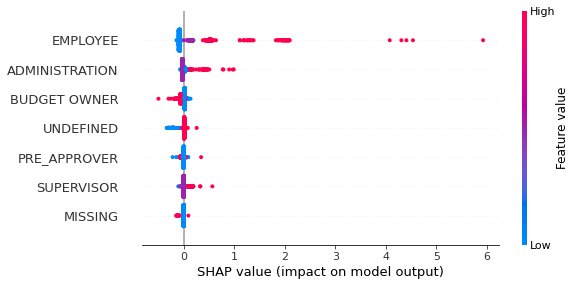

In [55]:
shap.summary_plot(shap_values,X_test_traces, feature_names=X_test_traces.columns)

In [60]:
X_test_traces

,EMPLOYEE,SUPERVISOR,UNDEFINED,PRE_APPROVER,MISSING,ADMINISTRATION,BUDGET OWNER
6009,2,1,0,0,0,1,0
2782,1,1,2,0,0,1,1
8238,1,1,2,1,0,0,0
8461,1,1,2,0,0,0,0
8545,1,1,2,1,0,0,0
...,...,...,...,...,...,...,...
4866,1,1,2,0,0,1,0
1142,1,1,2,0,0,1,1
6165,1,1,2,0,0,1,0
8628,1,1,2,0,0,0,0


In [65]:
#creo que si hacemos la media de shap values podemos sacar la importancia de cada valor
pd.DataFrame(shap_values,columns=X_test_traces.columns).mean().sort_values(ascending=False)

EMPLOYEE          0.003917
SUPERVISOR        0.002919
ADMINISTRATION    0.002089
MISSING          -0.000566
UNDEFINED        -0.002046
BUDGET OWNER     -0.002404
PRE_APPROVER     -0.002490
dtype: float64

In [ ]:
shap.waterfall_plot(a.base_values[0], shap_values[0], X[0])

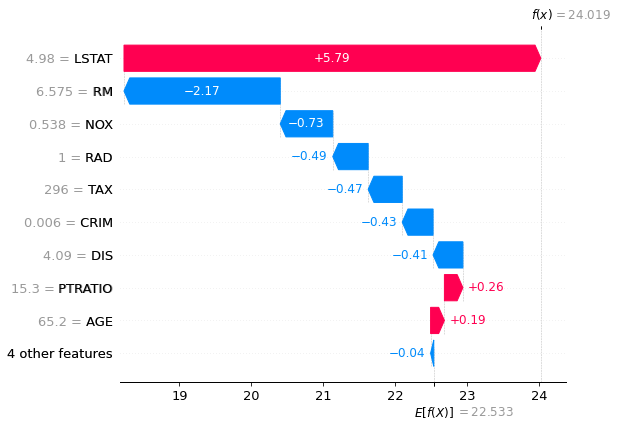

In [53]:
import xgboost
import shap

# train an XGBoost model
X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values2 = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values2[0])

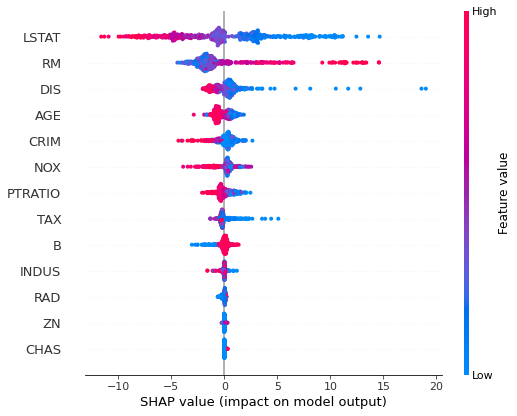

In [66]:
shap.summary_plot(shap_values2,X, feature_names=X.columns)